### Load training, validation and testing data

In [1]:
from data_helper import load_dataset

In [2]:
IMAGE_FOLDER_PATH = 'dataset/resized/frames/'
LABEL_FOLDER_PATH = 'dataset/labels/'

train_head_image_paths, train_hand_image_paths, train_labels, \
val_head_image_paths, val_hand_image_paths, val_labels, \
test_head_image_paths, test_hand_image_paths, test_labels = load_dataset(image_folder_path=IMAGE_FOLDER_PATH,
                                                                         label_folder_path=LABEL_FOLDER_PATH,
                                                                         label_type='obj',
                                                                         hand_types=['left', 'right'],
                                                                         with_head=True,
                                                                         validation_split_ratio=0.15)

# Only take hand image paths for baseline
train_image_paths =  train_hand_image_paths
val_image_paths = val_hand_image_paths
test_image_paths = test_hand_image_paths

----------------------------------------------------------------------------------------------------
[Train (Head)] number of image paths: 12744
[Train (Hand)] number of image paths: 12744
[Train (Label)] number of labels: 12744
----------------------------------------------------------------------------------------------------
[Validation (Head)] number of image paths: 2248
[Validation (Hand)] number of image paths: 2248
[Validation (Label)] number of labels: 2248
----------------------------------------------------------------------------------------------------
[Test (Head)] number of image paths: 12776
[Test (Hand)] number of image paths: 12776
[Test (Label)] number of labels: 12776


### Load logits from our models

In [3]:
import numpy as np

In [4]:
with open('model/hand_obj_vgg_16/hand_obj_vgg_16_model_logits.npy', 'rb') as file:
    hand_obj_vgg_16_model_logits = np.load(file)
    
with open('model/two_stream_vgg_16_baseline/two_stream_vgg_16_baseline_model_logits.npy', 'rb') as file:
    two_stream_vgg_16_baseline_model_logits = np.load(file)
    
with open('model/two_stream_vgg_16_multi_loss/two_stream_vgg_16_multi_loss_logits.npy', 'rb') as file:
    two_stream_vgg_16_multi_loss_logits = np.load(file)

### Build Tensorflow graph to convert logits to normalized probabilities

In [5]:
import tensorflow as tf

In [6]:
num_classes = 24 # Object recognition

graph = tf.Graph()
with graph.as_default():
    logits = tf.placeholder(dtype=tf.float32, shape=(None, num_classes), name='logits')
    prob_pred = tf.nn.softmax(logits, name='prob_pred') 

In [7]:
%%time

# Prevent GPUs from pre-allocating memory.
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(graph=graph, config=config) as sess:
    hand_obj_vgg_16_model_prob_pred  = sess.run(prob_pred, feed_dict={logits: hand_obj_vgg_16_model_logits})
    two_stream_vgg_16_baseline_model_prob_pred = sess.run(prob_pred, feed_dict={logits: two_stream_vgg_16_baseline_model_logits})
    two_stream_vgg_16_multi_loss_prob_pred = sess.run(prob_pred, feed_dict={logits: two_stream_vgg_16_multi_loss_logits})

CPU times: user 163 ms, sys: 699 ms, total: 862 ms
Wall time: 882 ms


### Building blocks for visualizeing
Here we'll plot precision-recall curve and confusion matrix for each model.

See [Micro-average and Macro-average of Precision, Recall and F-Score](http://rushdishams.blogspot.tw/2011/08/micro-and-macro-average-of-precision.html)

In [8]:
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import average_precision_score

%matplotlib inline

In [9]:
# Pre-defined class names for later plotting
class_names = ['free','computer','cellphone','coin','ruler','thermos-bottle','whiteboard-pen','whiteboard-eraser',
               'pen','cup','remote-control-TV','remote-control-AC','switch','windows','fridge','cupboard','water-tap',
               'toy','kettle','bottle','cookie','book','magnet','lamp-switch']

# Sanity check
assert(num_classes == len(class_names))

# Sparse labels to one-hot labels
test_onehot_labels = label_binarize(test_labels, classes=range(num_classes))

In [10]:
def cm2df(cm, class_names):
    """ Make sklearn's confusion matrix to dataframe """
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(class_names):
        rowdata={}
        # columns
        for j, col_label in enumerate(class_names): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[class_names]

def plot_confusion_matrix(cnf_matrix, class_names,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        title = 'Normalized {}'.format(title)
        
    df_cnf_matrix = cm2df(cnf_matrix, class_names)

    plt.figure(figsize=(16,9))
    if normalize:
        sns.heatmap(df_cnf_matrix, cmap="YlGnBu", annot=False)
    else:
        sns.heatmap(df_cnf_matrix, cmap="YlGnBu", annot=True, fmt='d')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_precision_recall_curve(num_classes, y_true, prob_pred):
    precision = {}
    recall = {}
    average_precision = {}

    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:,i], prob_pred[:,i])
        average_precision[i] = average_precision_score(y_true[:,i], prob_pred[:,i], average='macro')
        
    # A "micro-average": quantifying score on all classes jointly
    precision['micro'], recall['micro'], _ = precision_recall_curve(y_true.ravel(), prob_pred.ravel())
    average_precision['micro'] = average_precision_score(y_true, prob_pred, average='micro')
    
    # Start plotting
    lines = []
    labels = []
    plt.figure(figsize=(16, 9))
    
    # Micro-average precision-recall curve
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('Micro-average Precision-recall (area = {0:0.2f})'
                  ''.format(average_precision["micro"]))
    
    # Precision-recall curve per class
    for i in range(num_classes):
        l, = plt.plot(recall[i], precision[i], lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(i, average_precision[i]))
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Precision-Recall curve to multi-class')
    plt.legend(lines, labels, loc='upper right', prop=dict(size=10), bbox_to_anchor=(1.3, 1.01))
    plt.show()
    
    return precision, recall, average_precision

### Visualize our performance

#### Model 1: `hand_obj_vgg_16_model`

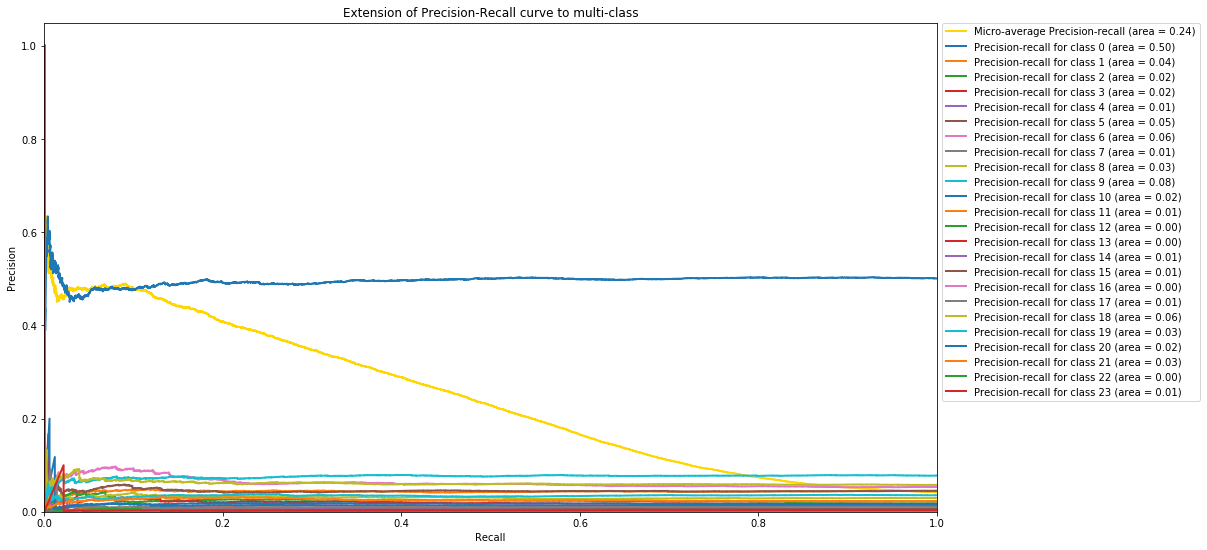

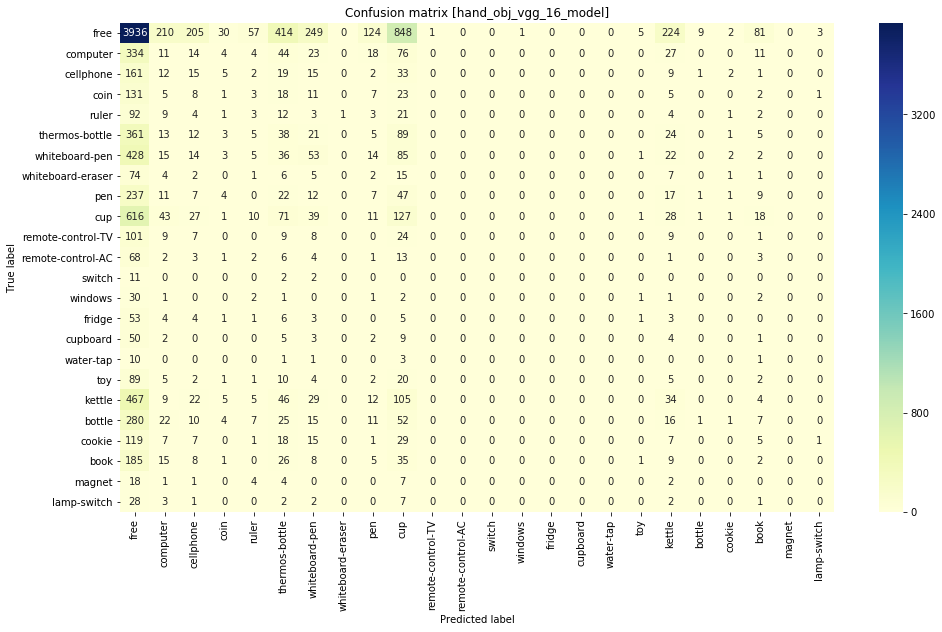

In [11]:
precision, recall, average_precision = \
    plot_precision_recall_curve(num_classes, test_onehot_labels, hand_obj_vgg_16_model_prob_pred)
    
cnf_matrix = confusion_matrix(y_true=test_labels,
                              y_pred=np.argmax(hand_obj_vgg_16_model_prob_pred, axis=1))

plot_confusion_matrix(cnf_matrix, class_names, normalize=False, title='Confusion matrix [hand_obj_vgg_16_model]')

#### Model 2: two_stream_vgg_16_baseline_model

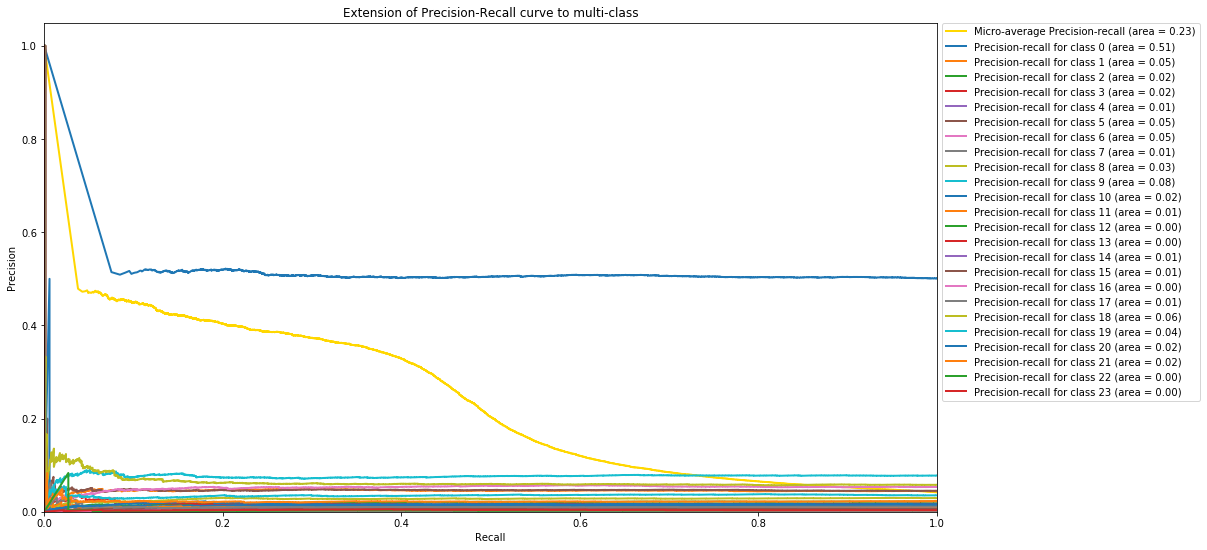

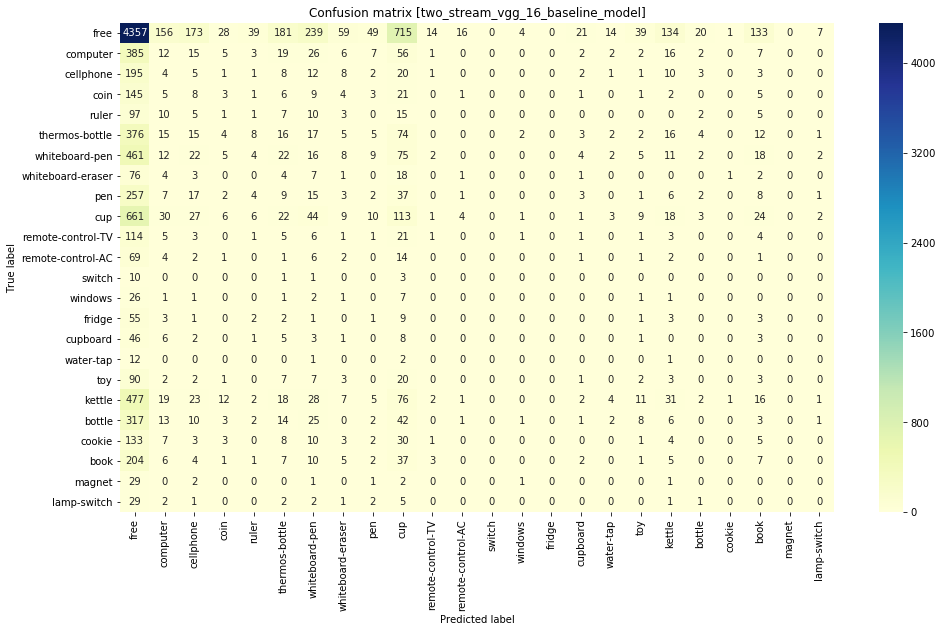

In [12]:
precision, recall, average_precision = \
    plot_precision_recall_curve(num_classes, test_onehot_labels, two_stream_vgg_16_multi_loss_prob_pred)
    
cnf_matrix = confusion_matrix(y_true=test_labels,
                              y_pred=np.argmax(two_stream_vgg_16_multi_loss_prob_pred, axis=1))

plot_confusion_matrix(cnf_matrix, class_names, normalize=False, title='Confusion matrix [two_stream_vgg_16_baseline_model]')

#### Model 3: two_stream_vgg_16_multi_loss

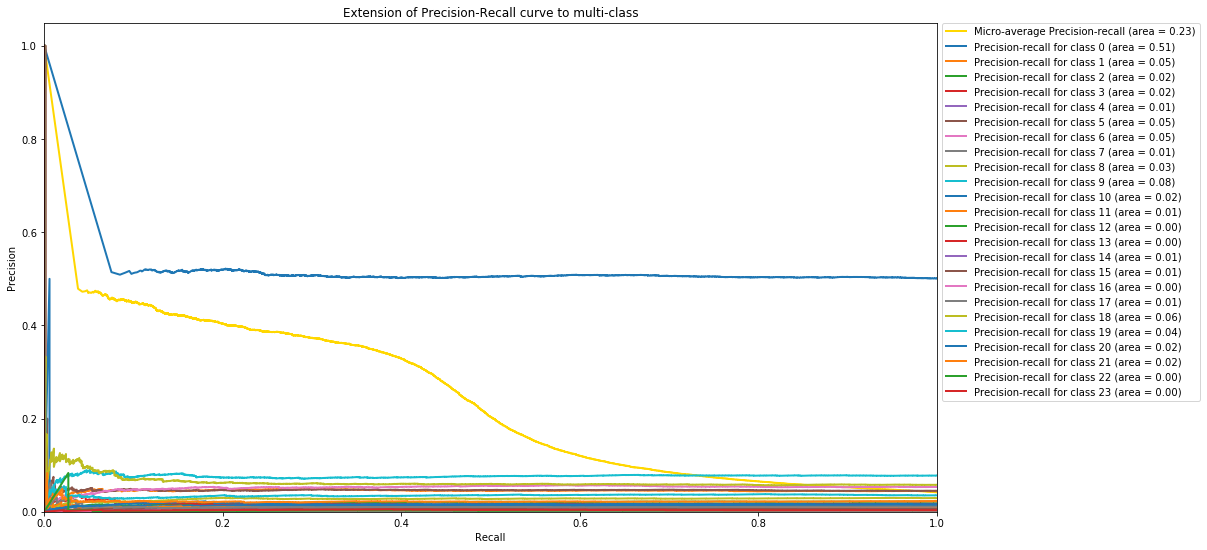

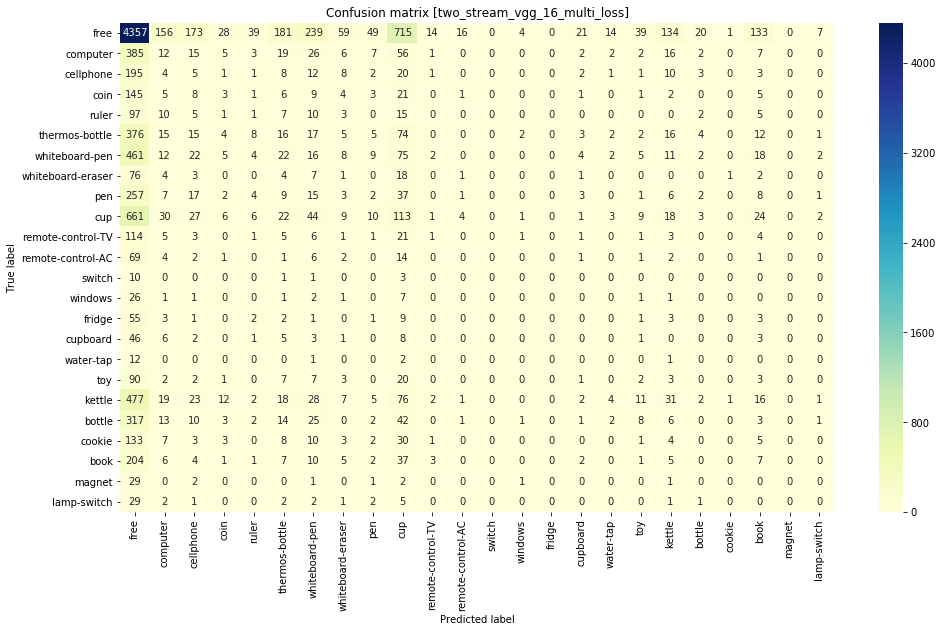

In [13]:
precision, recall, average_precision = \
    plot_precision_recall_curve(num_classes, test_onehot_labels, two_stream_vgg_16_multi_loss_prob_pred)
    
cnf_matrix = confusion_matrix(y_true=test_labels,
                              y_pred=np.argmax(two_stream_vgg_16_multi_loss_prob_pred, axis=1))

plot_confusion_matrix(cnf_matrix, class_names, normalize=False, title='Confusion matrix [two_stream_vgg_16_multi_loss]')